From (https://blog.keras.io/building-autoencoders-in-keras.html) By [Francois Chollet](https://twitter.com/fchollet)
# Autoencoders


![autoencoder](https://www.compthree.com/images/blog/ae/ae.png)

Usually, they are used for extracting latent representations with a lower dimensionality than the input data -> data compression 

## Case: MNIST handwritten digits

### Dataset: 

Train images: 60,000

Test images: 10,000

Image size: 28x28 pixels

![dataset](https://www.researchgate.net/profile/Steven_Young11/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset_W640.jpg)
![image of a digit](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2016/05/Examples-from-the-MNIST-dataset.png)




### Simplest autoencoder
We will use a single fully-connected neural for our encoder and decoder.

Elements:

Input Layer

* Input layer: $y = xI$

Encoder

* Fully-connected layer: $y = xA^T + b$
* Rectified Linear Unit function: $ReLu(x)=max(0, x)$ (encoder)

Decoder

* Fully-connected layer: $y = xW^T + b$
* Sigmoid function: $Sigmoid(x) = \sigma(x) = \frac{1}{1+exp(-x)}$ (decoder)

![autoencoder for MNIST](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

In [1]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# labels
print(y_train)

# data
print(x_train.shape)
print(x_test.shape)

x_train = x_train.astype('float32') / 255 # 255 max rgb value
x_test = x_test.astype('float32') / 255

#x_train = x_train.reshape(len(x_train), np.prod(x_train.shape[1:]))
#x_test = x_test.reshape(len(x_test), np.prod(x_test.shape[1:]))

x_train = x_train.reshape(len(x_train), 28,28,1)
x_test = x_test.reshape(len(x_test), 28,28,1)

number_of_pixels = np.prod(x_train.shape[1:])

print(number_of_pixels)
input_dim = x_train.shape[1:]

print(input_dim)

Using TensorFlow backend.


[5 0 4 ... 5 6 8]
(60000, 28, 28)
(10000, 28, 28)
784
(28, 28, 1)


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D , MaxPooling2D, Reshape, UpSampling2D,Attention
from tensorflow.keras.layers import Attention, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model # (template for architecture)

# latent representations dimension

# input layer
input_img = Input(shape=input_dim)

print(input_img.shape)
# encoder
print('...encoder.....')

conv1_layer = Conv2D(16, (3, 3), activation='relu', padding='same')
conv1_output = conv1_layer(input_img)

print(conv1_output.shape)

pool1_layer = MaxPooling2D((4, 4), padding='same')
pool1_output = pool1_layer (conv1_output)

print(pool1_output.shape)

#conv2_layer = Conv2D(32, (3, 3), activation='relu', padding='same')
#conv2_output = conv2_layer(pool1_output)

#print(conv2_output.shape)

#encoded =  MaxPooling2D((2, 2), padding='same')(conv2_output)

encoded = pool1_output

latent_dim = encoded.shape[1:]
print(latent_dim)
#........................................................................

print('...decoder.....')
conv1_decoder_layer = Conv2D(16, (3, 3), activation='relu', padding='same')
conv1_decoder_output = conv1_decoder_layer(encoded)
print(conv1_decoder_output.shape)

pool1_decoder = UpSampling2D((4, 4))
upsample1_decoder_out  = pool1_decoder(conv1_decoder_output)
print(upsample1_decoder_out.shape)


conv2_decoder_layer = Conv2D(1, (3, 3), activation='relu', padding='same')
conv2_decoder_output = conv2_decoder_layer(upsample1_decoder_out)
print(conv2_decoder_output.shape)

#pool2_decoder =  UpSampling2D((2, 2))
#upsample2_decoder_out  = pool2_decoder(conv2_decoder_output)
#print(upsample2_decoder_out.shape)

#conv3_decoder_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')
#decoded = conv3_decoder_layer (upsample2_decoder_out)
#print(decoded.shape)

decoded = conv2_decoder_output

(None, 28, 28, 1)
...encoder.....
(None, 28, 28, 16)
(None, 7, 7, 16)
(7, 7, 16)
...decoder.....
(None, 7, 7, 16)
(None, 28, 28, 16)
(None, 28, 28, 1)


In [3]:

simple_autoencoder = Model(input_img, decoded)
print(simple_autoencoder.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 16)          2320      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 1)         145       
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
___________________________________________________________

In [4]:
from tensorflow.keras.optimizers import Adadelta
simple_autoencoder.compile(optimizer=Adadelta(learning_rate=1.0), loss='binary_crossentropy')

Before training the model, we need to set up the loss function and optimizer.

Loss function per-pixel crossentropy loss

$y' = p(y)$

$loss = -[y * log(y' + \epsilon) + (1-y) * log(1-y' + \epsilon)]$


In [5]:
print(input_img.shape)
print(encoded.shape)
print(decoded.shape)


encoder_model = Model(input_img, encoded)
print(encoder_model.summary())



(None, 28, 28, 1)
(None, 7, 7, 16)
(None, 28, 28, 1)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 16)          0         
Total params: 160
Trainable params: 160
Non-trainable params: 0
_________________________________________________________________
None


In [6]:
encoded_input = Input(shape=encoded.shape)

# retrieve the last layer of the autoencoder model
#decoder_layer = autoencoder.layers[-1]
# create the decoder model
#decoder = Model(encoded_input, decoder_layer(encoded_input))

In [7]:
# Train model
simple_autoencoder.fit(x_train, x_train,  # the target is the same input data!
                       epochs=20, 
                       batch_size=256, 
                       shuffle=True, 
                       validation_data=(x_test, x_test)) 

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 36s 597us/sample - loss: 0.1942 - val_loss: 0.1407
Epoch 2/20
60000/60000 [==============================] - 35s 590us/sample - loss: 0.1374 - val_loss: 0.1300
Epoch 3/20
60000/60000 [==============================] - 36s 602us/sample - loss: 0.1312 - val_loss: 0.1244
Epoch 4/20
60000/60000 [==============================] - 38s 638us/sample - loss: 0.1280 - val_loss: 0.1219
Epoch 5/20
60000/60000 [==============================] - 35s 579us/sample - loss: 0.1241 - val_loss: 0.1204
Epoch 6/20
60000/60000 [==============================] - 37s 614us/sample - loss: 0.1223 - val_loss: 0.1193
Epoch 7/20
60000/60000 [==============================] - 35s 588us/sample - loss: 0.1231 - val_loss: 0.1179
Epoch 8/20
60000/60000 [==============================] - 39s 648us/sample - loss: 0.1199 - val_loss: 0.1545
Epoch 9/20
60000/60000 [==============================] - 37s 618us/sample - l

In [8]:
import matplotlib.pyplot as plt

def see_images(dataset, n):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(dataset[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

(10000, 28, 28, 1)
(28, 28)
(28, 28)


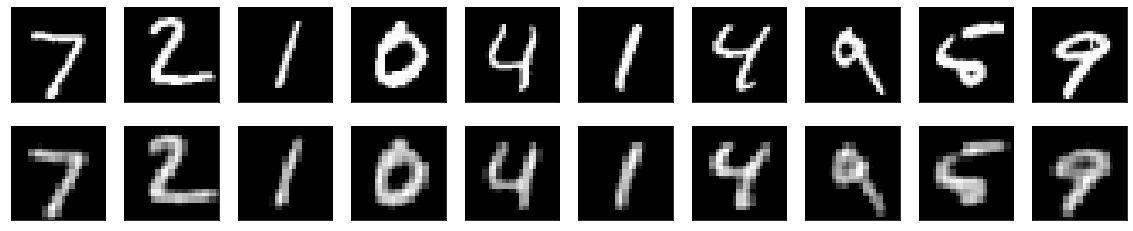

In [9]:
# Predict digits
decoded_imgs = simple_autoencoder.predict(x_test)
print(decoded_imgs.shape)

im = x_test[0].reshape(28, 28)
print(im.shape)

im = decoded_imgs[0].reshape(28, 28)
print(im.shape)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [10]:


############### ATTENTION ###############################





In [11]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# labels
print(y_train)

# data
print(x_train.shape)
print(x_test.shape)

x_train = x_train.astype('float32') / 255 # 255 max rgb value
x_test = x_test.astype('float32') / 255

#x_train = x_train.reshape(len(x_train), np.prod(x_train.shape[1:]))
#x_test = x_test.reshape(len(x_test), np.prod(x_test.shape[1:]))

x_train = x_train.reshape(len(x_train), 28,28,1)
x_test = x_test.reshape(len(x_test), 28,28,1)

number_of_pixels = np.prod(x_train.shape[1:])

print(number_of_pixels)
input_dim = x_train.shape[1:]

print(input_dim)

[5 0 4 ... 5 6 8]
(60000, 28, 28)
(10000, 28, 28)
784
(28, 28, 1)


In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D , MaxPooling2D, Reshape, UpSampling2D,Attention
from tensorflow.keras.layers import Attention, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model # (template for architecture)

# latent representations dimension

# input layer
input_img = Input(shape=input_dim)

print(input_img.shape)
# encoder
print('...encoder.....')

conv1_layer = Conv2D(16, (3, 3), activation='relu', padding='same')
conv1_output = conv1_layer(input_img)

print(conv1_output.shape)

(None, 28, 28, 1)
...encoder.....
(None, 28, 28, 16)


In [13]:

############################################### Attention block
print ('.................ATTENTION ...........................')

query = conv1_output
value = conv1_output

query_value_attention = Attention()([query, value])

print('attention output shape' + str(query_value_attention))

#Concatenate query and document encodings to produce a DNN input layer.
final_out_attention = Concatenate(axis=-1)([query, query_value_attention])

#query_pooled = GlobalAveragePooling2D()(query)
#query_value_attention_pooled = GlobalAveragePooling2D()(query_value_attention)

#print('image_encoded after pooling shape' + str(query_pooled))
#print('attention output after pooling shape' + str(query_value_attention_pooled))

# Concatenate query and document encodings to produce a DNN input layer.
#final_out_attention = Concatenate(axis=0)([query_pooled, query_value_attention_pooled])


print('final_out_attentio' + str(final_out_attention))
##############################################




.................ATTENTION ...........................
attention output shapeTensor("attention/Identity:0", shape=(None, 28, 28, 16), dtype=float32)
final_out_attentioTensor("concatenate/Identity:0", shape=(None, 28, 28, 32), dtype=float32)


In [14]:


pool1_layer = MaxPooling2D((4, 4), padding='same')
pool1_output = pool1_layer (final_out_attention)

print(pool1_output.shape)

#conv2_layer = Conv2D(32, (3, 3), activation='relu', padding='same')
#conv2_output = conv2_layer(pool1_output)

#print(conv2_output.shape)

#encoded =  MaxPooling2D((2, 2), padding='same')(conv2_output)

encoded = pool1_output

latent_dim = encoded.shape[1:]
print(latent_dim)

(None, 7, 7, 32)
(7, 7, 32)


In [15]:

#........................................................................

print('...decoder.....')
conv1_decoder_layer = Conv2D(16, (3, 3), activation='relu', padding='same')
conv1_decoder_output = conv1_decoder_layer(encoded)
print(conv1_decoder_output.shape)

pool1_decoder = UpSampling2D((4, 4))
upsample1_decoder_out  = pool1_decoder(conv1_decoder_output)
print(upsample1_decoder_out.shape)


conv2_decoder_layer = Conv2D(1, (3, 3), activation='relu', padding='same')
conv2_decoder_output = conv2_decoder_layer(upsample1_decoder_out)
print(conv2_decoder_output.shape)

#pool2_decoder =  UpSampling2D((2, 2))
#upsample2_decoder_out  = pool2_decoder(conv2_decoder_output)
#print(upsample2_decoder_out.shape)

#conv3_decoder_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')
#decoded = conv3_decoder_layer (upsample2_decoder_out)
#print(decoded.shape)

decoded = conv2_decoder_output

...decoder.....
(None, 7, 7, 16)
(None, 28, 28, 16)
(None, 28, 28, 1)


In [16]:
attention_autoencoder = Model(input_img, decoded)
print(attention_autoencoder.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 28, 28, 16)   160         input_3[0][0]                    
__________________________________________________________________________________________________
attention (Attention)           (None, 28, 28, 16)   0           conv2d_3[0][0]                   
                                                                 conv2d_3[0][0]                   
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 28, 28, 32)   0           conv2d_3[0][0]             

In [17]:
from tensorflow.keras.optimizers import Adadelta
attention_autoencoder.compile(optimizer=Adadelta(learning_rate=1.0), loss='binary_crossentropy')

In [18]:
print(input_img.shape)
print(encoded.shape)
print(decoded.shape)


encoder_model = Model(input_img, encoded)
print(encoder_model.summary())


(None, 28, 28, 1)
(None, 7, 7, 32)
(None, 28, 28, 1)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 28, 28, 16)   160         input_3[0][0]                    
__________________________________________________________________________________________________
attention (Attention)           (None, 28, 28, 16)   0           conv2d_3[0][0]                   
                                                                 conv2d_3[0][0]                   
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 

In [19]:
encoded_input = Input(shape=encoded.shape)

# retrieve the last layer of the autoencoder model
#decoder_layer = autoencoder.layers[-1]
# create the decoder model
#decoder = Model(encoded_input, decoder_layer(encoded_input))

In [20]:
attention_autoencoder.fit(x_train, x_train,  # the target is the same input data!
                       epochs=20, 
                       batch_size=256, 
                       shuffle=True, 
                       validation_data=(x_test, x_test)) 

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 59s 982us/sample - loss: 0.1797 - val_loss: 0.1480
Epoch 2/20
60000/60000 [==============================] - 63s 1ms/sample - loss: 0.1485 - val_loss: 0.1376
Epoch 3/20
60000/60000 [==============================] - 64s 1ms/sample - loss: 0.1395 - val_loss: 0.1312
Epoch 4/20
60000/60000 [==============================] - 61s 1ms/sample - loss: 0.1327 - val_loss: 0.1282
Epoch 5/20
60000/60000 [==============================] - 64s 1ms/sample - loss: 0.1290 - val_loss: 0.1339
Epoch 6/20
60000/60000 [==============================] - 62s 1ms/sample - loss: 0.1265 - val_loss: 0.1212
Epoch 7/20
60000/60000 [==============================] - 59s 981us/sample - loss: 0.1262 - val_loss: 0.1216
Epoch 8/20
60000/60000 [==============================] - 73s 1ms/sample - loss: 0.1230 - val_loss: 0.1186
Epoch 9/20
60000/60000 [==============================] - 67s 1ms/sample - loss: 0.1228 - 

(10000, 28, 28, 1)
(28, 28)
(28, 28)


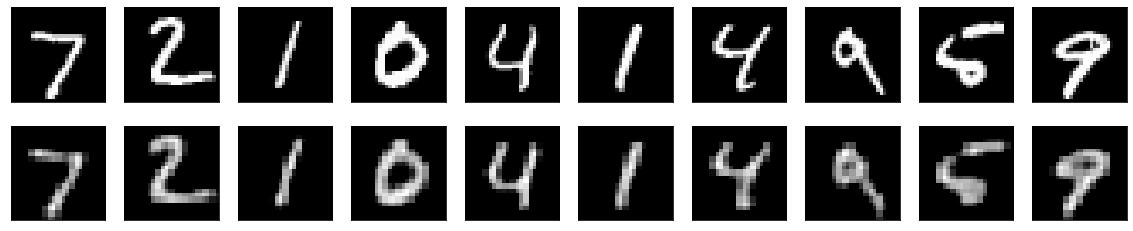

In [21]:
# Predict digits
decoded_imgs = attention_autoencoder.predict(x_test)
print(decoded_imgs.shape)
im = x_test[0].reshape(28, 28)
print(im.shape)

im = decoded_imgs[i].reshape(28, 28)
print(im.shape)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
















New model: Autoencoder + Attention












